# 深層学習を用いた「オセロAI」_AlphaZero

## ゲーム環境の構築


In [ ]:
# セル1: ゲーム環境
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import time
from tqdm import tqdm # 進捗表示用

class OthelloGame:
    def __init__(self, n=8):
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        self.board[mid-1, mid-1] = self.board[mid, mid] = 1
        self.board[mid-1, mid] = self.board[mid, mid-1] = -1
        self.current_player = -1

    def get_valid_moves(self, player):
        valid_moves = []
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r, c] == 0:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0: continue
                            r_check, c_check = r + dr, c + dc
                            flipped_stones = []
                            while 0 <= r_check < self.n and 0 <= c_check < self.n:
                                if self.board[r_check, c_check] == -player:
                                    flipped_stones.append((r_check, c_check))
                                    r_check += dr
                                    c_check += dc
                                elif self.board[r_check, c_check] == player:
                                    if flipped_stones: valid_moves.append((r, c))
                                    break
                                else: break
        return list(set(valid_moves))

    def make_move(self, move, player):
        if move is None: return
        r, c = move
        self.board[r, c] = player
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0: continue
                r_check, c_check = r + dr, c + dc
                flipped_stones = []
                while 0 <= r_check < self.n and 0 <= c_check < self.n:
                    if self.board[r_check, c_check] == -player:
                        flipped_stones.append((r_check, c_check))
                        r_check += dr
                        c_check += dc
                    elif self.board[r_check, c_check] == player:
                        for fr, fc in flipped_stones: self.board[fr, fc] = player
                        break
                    else: break

    def is_game_over(self):
        return not self.get_valid_moves(-1) and not self.get_valid_moves(1)

    def get_winner(self):
        black_stones = np.sum(self.board == -1)
        white_stones = np.sum(self.board == 1)
        if black_stones > white_stones: return -1
        elif white_stones > black_stones: return 1
        else: return 0

    def get_board_state(self):
        return self.board.copy()

    def get_symmetries(self, board, pi):
        # 盤面と方策を回転・反転させて学習データを増やす
        pi_board = np.reshape(pi, (self.n, self.n))
        symmetries = []
        for i in range(4):
            for j in [True, False]:
                new_b = np.rot90(board, i)
                new_pi = np.rot90(pi_board, i)
                if j:
                    new_b = np.fliplr(new_b)
                    new_pi = np.fliplr(new_pi)
                symmetries.append((new_b, new_pi.flatten()))
        return symmetries

## ニューラルネットワークとMCTSの実装
AlphaZero方式の心臓部。ResNet風の構造を持つネットワークと、MCTSのロジックを実装

In [ ]:
# セル2: ニューラルネットワークとMCTS


# --- 1. ニューラルネットワーク ---
class ResBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class AlphaNet(nn.Module):
    def __init__(self, n=8, num_res_blocks=5, num_filters=64):
        super(AlphaNet, self).__init__()
        self.n = n
        self.start_block = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.res_blocks = nn.ModuleList([ResBlock(num_filters) for _ in range(num_res_blocks)])
        self.policy_conv = nn.Conv2d(num_filters, 2, kernel_size=1)
        self.policy_fc = nn.Linear(2 * n * n, n * n)
        self.value_conv = nn.Conv2d(num_filters, 1, kernel_size=1)
        self.value_fc1 = nn.Linear(n * n, 256)
        self.value_fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, 1, self.n, self.n)
        x = self.start_block(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        pi = F.relu(self.policy_conv(x))
        pi = pi.view(pi.size(0), -1)
        pi = self.policy_fc(pi)
        pi = F.log_softmax(pi, dim=1)
        v = F.relu(self.value_conv(x))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))
        return pi, v

# --- 2. モンテカルロ木探索 (MCTS)  ---
class MCTS:
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}
        self.Nsa = {}
        self.Ns = {}
        self.Ps = {}

    def get_action_prob(self, canonical_board, temp=1):
        # シミュレーションの開始
        for _ in range(self.args['num_sims']):
            # 毎回、元の盤面のコピーから探索を開始する
            sim_game = OthelloGame(self.game.n)
            sim_game.board = np.copy(canonical_board)
            sim_game.current_player = 1 # Canonical Board is always from player 1's perspective
            self.search(sim_game)

        s = str(canonical_board.tobytes())
        counts = [self.Nsa.get((s, a), 0) for a in range(self.game.n * self.game.n)]

        if temp == 0:
            best_a = np.argmax(counts)
            probs = [0] * len(counts)
            probs[best_a] = 1
            return probs

        counts = [c**(1./temp) for c in counts]
        probs_sum = float(sum(counts))
        if probs_sum == 0: # 全てのカウントが0の場合（ありえないはずだが安全策）
            valid_moves = self.game.get_valid_moves(1)
            num_valid_moves = len(valid_moves)
            probs = [0] * len(counts)
            if num_valid_moves > 0:
                prob_per_move = 1 / num_valid_moves
                for r, c in valid_moves:
                    probs[r * self.game.n + c] = prob_per_move
            return probs

        probs = [x / probs_sum for x in counts]
        return probs

    def search(self, sim_game):
        s = str(sim_game.board.tobytes())

        # Base Case 1: 終端ノード (ゲーム終了)
        if sim_game.is_game_over():
            return -sim_game.get_winner()

        # Base Case 2: リーフノード (未探索)
        if s not in self.Ps:
            board_tensor = torch.FloatTensor(sim_game.board).unsqueeze(0).to(self.args['device'])
            log_pi, v = self.nnet(board_tensor)
            self.Ps[s] = torch.exp(log_pi).data.cpu().numpy()[0]
            self.Ns[s] = 0
            return -v.item()

        # --- Selection ---
        valid_moves = sim_game.get_valid_moves(sim_game.current_player)
        if not valid_moves: # パスの場合は相手ターンへ
            sim_game.current_player *= -1
            return -self.search(sim_game) # 相手視点での探索結果を返す

        valid_actions = [r * self.game.n + c for r, c in valid_moves]
        best_uct = -float('inf')
        best_a = -1

        for a in valid_actions:
            if (s, a) in self.Qsa:
                uct = self.Qsa[(s, a)] + self.args['cpuct'] * self.Ps[s][a] * np.sqrt(self.Ns[s]) / (1 + self.Nsa[(s, a)])
            else:
                uct = self.args['cpuct'] * self.Ps[s][a] * np.sqrt(self.Ns[s] + 1e-8)
            if uct > best_uct:
                best_uct = uct
                best_a = a

        a = best_a

        # --- Expansion ---
        # 次の盤面の状態を「コピー」して再帰呼び出し
        next_sim_game = OthelloGame(self.game.n)
        next_sim_game.board = np.copy(sim_game.board)
        next_sim_game.current_player = sim_game.current_player

        next_sim_game.make_move((a // self.game.n, a % self.game.n), next_sim_game.current_player)
        next_sim_game.current_player *= -1

        # --- Backpropagation ---
        v = self.search(next_sim_game)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1
        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v

## アリーナの実装
2つの異なるネットワークモデルを対戦させるためのクラスを新しく作成




In [ ]:
# セル3: アリーナ (モデル評価対戦)
class Arena():
    def __init__(self, player1, player2, game, args):
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.args = args

    def playGame(self, verbose=False):
        players = [self.player2, None, self.player1]
        current_player_idx = -1
        game = OthelloGame(self.game.n)
        it = 0

        while not game.is_game_over():
            it += 1
            player_in_turn = players[current_player_idx + 1]
            canonical_board = game.get_board_state() * current_player_idx

            # MCTSを使った手番決定
            mcts = MCTS(OthelloGame(self.game.n), player_in_turn, self.args)
            mcts.game.board = np.copy(game.board)
            mcts.game.current_player = current_player_idx

            action_probs = mcts.get_action_prob(canonical_board, temp=0) # 最善手を選択
            action = np.argmax(action_probs)

            game.make_move((action // self.game.n, action % self.game.n), current_player_idx)
            current_player_idx *= -1

        return game.get_winner()

    def playGames(self, num_games, verbose=False):
        num_games = int(num_games / 2)
        one_wins = 0
        two_wins = 0
        draws = 0

        for _ in tqdm(range(num_games), desc="Arena (P1 vs P2)"):
            game_result = self.playGame(verbose=verbose)
            if game_result == -1: one_wins += 1
            elif game_result == 1: two_wins += 1
            else: draws += 1

        self.player1, self.player2 = self.player2, self.player1 # 先手後手を入れ替え

        for _ in tqdm(range(num_games), desc="Arena (P2 vs P1)"):
            game_result = self.playGame(verbose=verbose)
            if game_result == 1: one_wins += 1
            elif game_result == -1: two_wins += 1
            else: draws += 1

        return one_wins, two_wins, draws

## 学習の実装
学習ループにアリーナでの評価を追加し、結果をhistoryに記録

In [ ]:
# セル4: 学習の実行

class Coach:
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.pnet = self.nnet.__class__(game.n).to(args['device']) # 前のモデル(previous net)
        self.args = args
        self.train_examples_history = []
        self.optimizer = optim.Adam(self.nnet.parameters(), lr=args['lr'])
        self.history = {'arena_win_rate': [], 'loss_pi': [], 'loss_v': []}

    def execute_episode(self):
        # ... (このメソッドは変更なし、前回のコードをそのまま使用) ...
        train_examples = []
        game = OthelloGame(self.game.n)
        current_player = -1
        episode_step = 0
        while True:
            episode_step += 1
            canonical_board = game.get_board_state() * current_player
            temp = int(episode_step < self.args['temp_threshold'])
            mcts = MCTS(OthelloGame(self.game.n), self.nnet, self.args)
            mcts.game.board = np.copy(game.board)
            mcts.game.current_player = current_player
            pi = mcts.get_action_prob(canonical_board, temp=temp)
            for b, p in self.game.get_symmetries(canonical_board, pi):
                train_examples.append([b, current_player, p])
            action = np.random.choice(len(pi), p=pi)
            game.make_move((action // self.game.n, action % self.game.n), current_player)
            if game.is_game_over():
                winner = game.get_winner()
                return [(x[0], x[2], winner * x[1]) for x in train_examples]
            current_player *= -1

    def learn(self):
        for i in range(1, self.args['num_iters'] + 1):
            print(f'------ ITERATION {i} ------')

            # --- 1. 自己対戦 ---
            iteration_train_examples = deque(maxlen=self.args['max_len_of_queue'])
            for _ in tqdm(range(self.args['num_episodes']), desc="Self Play"):
                iteration_train_examples += self.execute_episode()

            self.train_examples_history.append(iteration_train_examples)
            if len(self.train_examples_history) > self.args['num_iters_for_train_examples_history']:
                self.train_examples_history.pop(0)
            train_examples = []
            for e in self.train_examples_history:
                train_examples.extend(e)
            random.shuffle(train_examples)

            # --- 2. ネットワーク学習 ---
            self.pnet.load_state_dict(self.nnet.state_dict()) # 学習前のモデルを保存
            avg_loss_pi, avg_loss_v = self.train(train_examples)
            self.history['loss_pi'].append(avg_loss_pi)
            self.history['loss_v'].append(avg_loss_v)

            # --- 3. アリーナでの評価 ---
            print('ARENA star PITTING NEW MODEL VS PREVIOUS MODEL')
            arena = Arena(self.nnet, self.pnet, self.game, self.args)
            pwins, nwins, draws = arena.playGames(self.args['arena_compare'])
            win_rate = nwins / (pwins + nwins + draws) if (pwins + nwins + draws) > 0 else 0
            self.history['arena_win_rate'].append(win_rate)

            print(f'NEW/PREV WINS : {nwins} / {pwins} ; DRAWS : {draws}')
            print(f'WIN RATE of NEW MODEL: {win_rate:.4f}')

            if win_rate > self.args['update_threshold']:
                print('ACCEPTING NEW MODEL')
                torch.save(self.nnet.state_dict(), f'checkpoint_{i}.pth.tar')
                torch.save(self.nnet.state_dict(), 'best.pth.tar')
            else:
                print('REJECTING NEW MODEL')
                self.nnet.load_state_dict(self.pnet.state_dict())

        return self.history


    def train(self, examples):
        # ... (損失を返すように少し修正) ...
        self.nnet.train()
        total_loss_pi, total_loss_v = 0, 0

        for epoch in range(self.args['epochs']):
            batch_count = int(len(examples) / self.args['batch_size'])
            for _ in range(batch_count):
                sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = torch.FloatTensor(np.array(boards)).to(self.args['device'])
                target_pis = torch.FloatTensor(np.array(pis)).to(self.args['device'])
                target_vs = torch.FloatTensor(np.array(vs)).to(self.args['device'])

                out_pi, out_v = self.nnet(boards)
                l_pi = -torch.sum(target_pis * out_pi) / target_pis.size()[0]
                l_v = F.mse_loss(out_v.view(-1), target_vs)
                total_loss = l_pi + l_v

                total_loss_pi += l_pi.item()
                total_loss_v += l_v.item()

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

        return total_loss_pi / batch_count, total_loss_v / batch_count

## 実行と可視化
学習パラメータにアリーナ関連のものを追加し、最後にグラフを描画するコードを付け加える

Using device: cuda
------ ITERATION 1 ------


Self Play: 100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


NEW/PREV WINS : 0 / 20 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.0000
REJECTING NEW MODEL
------ ITERATION 2 ------


Self Play: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


NEW/PREV WINS : 0 / 20 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.0000
REJECTING NEW MODEL
------ ITERATION 3 ------


Self Play: 100%|██████████| 20/20 [01:22<00:00,  4.12s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


NEW/PREV WINS : 0 / 20 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.0000
REJECTING NEW MODEL
------ ITERATION 4 ------


Self Play: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


NEW/PREV WINS : 10 / 10 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.5000
REJECTING NEW MODEL
------ ITERATION 5 ------


Self Play: 100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:41<00:00,  4.10s/it]


NEW/PREV WINS : 20 / 0 ; DRAWS : 0
WIN RATE of NEW MODEL: 1.0000
ACCEPTING NEW MODEL
------ ITERATION 6 ------


Self Play: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


NEW/PREV WINS : 20 / 0 ; DRAWS : 0
WIN RATE of NEW MODEL: 1.0000
ACCEPTING NEW MODEL
------ ITERATION 7 ------


Self Play: 100%|██████████| 20/20 [01:23<00:00,  4.20s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


NEW/PREV WINS : 20 / 0 ; DRAWS : 0
WIN RATE of NEW MODEL: 1.0000
ACCEPTING NEW MODEL
------ ITERATION 8 ------


Self Play: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


NEW/PREV WINS : 10 / 0 ; DRAWS : 10
WIN RATE of NEW MODEL: 0.5000
REJECTING NEW MODEL
------ ITERATION 9 ------


Self Play: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


NEW/PREV WINS : 0 / 20 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.0000
REJECTING NEW MODEL
------ ITERATION 10 ------


Self Play: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


ARENA star PITTING NEW MODEL VS PREVIOUS MODEL


Arena (P2 vs P1): 100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


NEW/PREV WINS : 10 / 10 ; DRAWS : 0
WIN RATE of NEW MODEL: 0.5000
REJECTING NEW MODEL


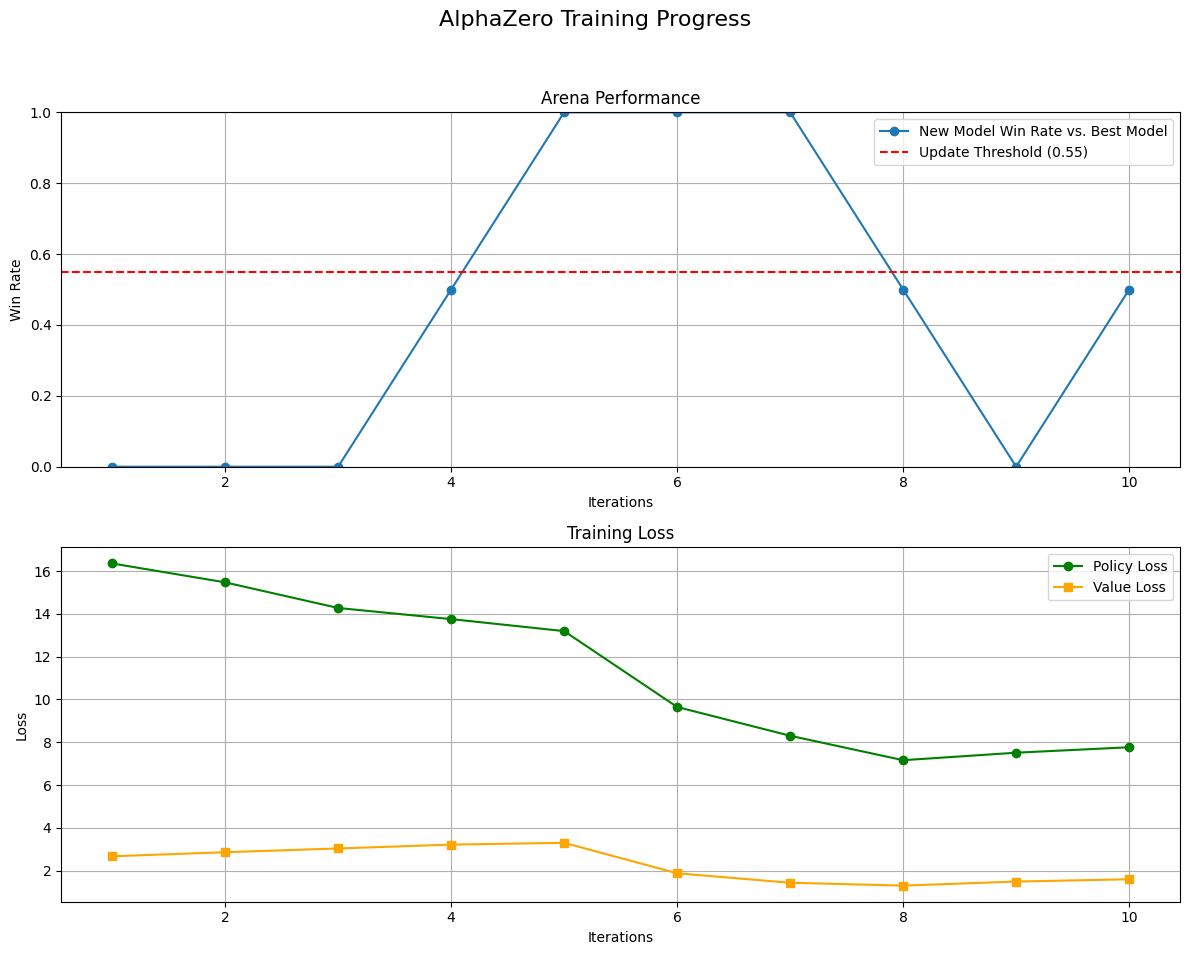

In [ ]:
# セル5: パラメータ設定、実行、可視化

import matplotlib.pyplot as plt

args = {
    'num_iters': 10,                 # 総学習イテレーション数
    'num_episodes': 20,              # 1イテレーションあたりの自己対戦ゲーム数
    'temp_threshold': 15,
    'num_sims': 20,                  # MCTSのシミュレーション回数
    'cpuct': 1.0,

    # --- アリーナ関連 ---
    'arena_compare': 20,             # 評価対戦のゲーム数 (偶数)
    'update_threshold': 0.55,        # 新モデルがチャンピオンになるための勝率閾値

    'lr': 0.001,
    'epochs': 5,
    'batch_size': 64,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'max_len_of_queue': 200000,
    'num_iters_for_train_examples_history': 20,
}

def main_and_visualize():
    print(f"Using device: {args['device']}")
    game = OthelloGame()
    nnet = AlphaNet(n=game.n).to(args['device'])
    coach = Coach(game, nnet, args)

    # --- 学習開始 ---
    history = coach.learn()

    # --- 可視化 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('AlphaZero Training Progress', fontsize=16)

    # 1. アリーナでの勝率の推移
    ax1.plot(range(1, len(history['arena_win_rate']) + 1), history['arena_win_rate'], marker='o', label='New Model Win Rate vs. Best Model')
    ax1.axhline(y=args['update_threshold'], color='r', linestyle='--', label=f'Update Threshold ({args["update_threshold"]})')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Win Rate')
    ax1.set_title('Arena Performance')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 1)

    # 2. 損失の推移
    ax2.plot(range(1, len(history['loss_pi']) + 1), history['loss_pi'], marker='o', color='green', label='Policy Loss')
    ax2.plot(range(1, len(history['loss_v']) + 1), history['loss_v'], marker='s', color='orange', label='Value Loss')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    main_and_visualize()

##